上一篇文章写过这个问题，这里用另一组数据再分析一遍。

本次数据来自https://zhuanlan.zhihu.com/p/38020604
## 电信运营商客户流失风险分析
对于一家公司，了解客户流失情况，对于后续经营是非常重要的。以下通过分析运营商中客户的使用情况，可以预测出将来是否会流失。
数据来自https://www.kesci.com/home/dataset/5e43f8b25f2816002ceb69d6

In [4]:
file='C:/Users/wade z shao/Documents/GitHub/yunzhuan/growth-workshop/data/churn.csv'

In [33]:
from __future__ import division
import pandas
import numpy
import matplotlib.pyplot as plt

In [34]:
data=pandas.read_csv(file)
print(data.head())
print(data.info())

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7 

In [99]:
col_names = data.columns.tolist()
print ("----\nColumn names:\n",col_names)

to_show = col_names[:6] + col_names[-6:]

print ("\n-----\nSample data:\n",data[to_show].head(6))

----
Column names:
 ['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

-----
Sample data:
   State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   
5    AL             118        510  391-8027        yes         no   

   Night Charge  Intl Mins  Intl Calls  Intl Charge  CustServ Calls  Churn?  
0         11.01       10.0           3         2.70               1  False.  
1         11.45       13

我们将针对这个例子保持这个例子的统计模型，从而使特征区域几乎不改变，如上所示。以下代码将不相关的列删去，并将字符串转换为布尔值（因为模型不会很好地处理“yes”和“no”）。 其余的数字列保持不变。

In [107]:
# 将Churn？列单独复制给元组，并转为bool
churn_result = data['Churn?']
y = numpy.where(churn_result == 'True.',1,0)

In [108]:
# 将无关列删除
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = data.drop(to_drop,axis=1)

In [109]:
# ‘yes’或‘no'转为bool类型
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

In [110]:
# 将即将要用到的列名输出
features = churn_feat_space.columns
print (features)

Index(['Account Length', 'Int'l Plan', 'VMail Plan', 'VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')


In [104]:
X = churn_feat_space.iloc[:,:].values.astype(numpy.float)
print(X)
# X = churn_feat_space.as_matrix().astype(numpy.float)
#AttributeError: 'DataFrame' object has no attribute 'as_matrix'

#pip install -i https://pypi.tuna.tsinghua.edu.cn/simple sklearn
from sklearn.model_selection import KFold
# from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
# 此处非常重要
scaler = StandardScaler()
X = scaler.fit_transform(X)
print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", numpy.unique(y))

[[128.     0.     1.   ...   3.     2.7    1.  ]
 [107.     0.     1.   ...   3.     3.7    1.  ]
 [137.     0.     0.   ...   5.     3.29   0.  ]
 ...
 [ 28.     0.     0.   ...   6.     3.81   2.  ]
 [184.     1.     0.   ...  10.     1.35   2.  ]
 [ 74.     0.     1.   ...   4.     3.7    0.  ]]
Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


许多预测者关注于不同特征的相对大小，即使这些标度可能是任意的。例如：篮球队每场比赛得分的分数自然比他们的胜率要大几个数量级。但这并不意味着后者的重要性低100倍。StandardScaler通过将每个特征归一化到大约1.0到-1.0的范围来修复这个问题，从而防止模型不正确。

我现在有一个特征空间’X’和一组目标值’y’。

### 模型效率
快递，测试，循环。机器学习管道不应该是静态的。总是有新的特征，新的数据来使用，新的分类器考虑每个唯一的参数调整。对于每一个变化，至关重要的是能够将新得到的参数与之前的进行对比。

作为一个好的开始，交叉验证尝试避免过拟合（对同一数据点进行训练和预测），同时仍然为每个观测数据集产生预测。这是通过在训练一组模型的同时系统地隐藏数据的不同子集来实现的。在训练之后，每个模型对已隐藏的子集进行预测，产生多次不同的训练-测试集的分隔。当正确地完成时，每个观察将具有“公平”对应的预测。

In [111]:
#使用sklearn库

from sklearn.model_selection import KFold
# from sklearn.cross_validation import KFold

def run_cv(X,y,clf_class,**kwargs):
    # 构造交叉验证对象
    kf = KFold(len(y),n_folds=3,shuffle=True)
    y_pred = y.copy()
    
    # 循环训练-交叉集的集合
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # 通过关键字元素初始化分类器
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

我们来比较三个相当独特的算法，支持向量机，随机森林和knn。通过交叉验证来明确分类器的正确率。

In [112]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true,y_pred):
    # NumPy将TRUE/FALSE对应于1.0/0.0
    return np.mean(y_true == y_pred)

print ("Logistic Regression:")
print ("%.3f" % accuracy(y, run_cv(X,y,LR) ) )
print ("Gradient Boosting Classifier")
print ("%.3f" % accuracy(y, run_cv(X,y,GBC)))
print ("Support vector machines:")
print ("%.3f" % accuracy(y, run_cv(X,y,SVC)))
print ("Random forest:")
print ("%.3f" % accuracy(y, run_cv(X,y,RF)))
print ("K-nearest-neighbors:")
print ("%.3f" % accuracy(y, run_cv(X,y,KNN)))

Logistic Regression:


TypeError: __init__() got an unexpected keyword argument 'n_folds'

根据以上数据，随机森林的分类效果更佳。

### 精确率和召回率
计算的数值并不能总是良好的区分好模型与坏模型。它们传达了对模型性能的一些感性认知，而每个数值的有效性与否是由分析者所决定的。准确性的问题在于每次的结果并不一定相同。如果我的分类器预测客户会流失，而实际上他们没有，这不是最好的分类结果，但这个结果是可以被原谅的。然而，如果我的分类器预测客户会留下，因而我就没有发现他们实际上是要流失的客户…那这就是糟糕的分类结果。

我将使用另一个内置的scikit-learn函数来构造混淆矩阵。混淆矩阵是一种将分类器预测结果的可视化的方法，并且仅仅是一个表格，其示出了对于特定类的预测的分布。x轴表示每个观察的真实类别（如果客户流失或不流失），而y轴对应于模型预测的类别（如果我的分类器表示客户会流失或不流失）。

In [114]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = numpy.array(y)
class_names = numpy.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y,run_cv(X,y,GBC)) ),
    ( "Logisitic Regression", confusion_matrix(y,run_cv(X,y,LR)) )
]

# Pyplot code not included to reduce clutter
# from churn_display import draw_confusion_matrices
%matplotlib inline

draw_confusion_matrices(confusion_matrices,class_names)

TypeError: __init__() got an unexpected keyword argument 'n_folds'

要注意的是当客户流失时，分类器的预测正确率如何？这种计算方法被成为召回率，并且快速查看图片可以证明迭代决策树和随机森林在这个标准的计算方法判定上是表现最佳的。在召回率上迭代决策树和随机森林中都达到了大约70%，相比于其他的分类方法远远领先。

另一个要注意的问题是当分类器预测出某用户会流失时，该用户究竟是否会流失？这种计算方法叫做精确度。可以发现在这个计算方法中，突出的仍旧是迭代决策树和随机森林。在精确度上都达到了大约90%，支持向量机也达到了88%。knn算法中也稍微滞后，达到了80%。

然而就如准确度、精确度和召回率中随机森林和迭代决策树都优于其他的分类方法，但是并不是在所有的情形中，这两类分类方法都能够优于其他的分类方法。而如果不同的计算方法中返回了不同的优劣排序，那么针对于不同计算方法中所包含的内容和价值，就能够选出最适合的分类方法。

### ROC 曲线 & AUC
另一个重要的指标是ROC图。

简而言之，ROC曲线下的面积（AUC）是将查看ROC曲线的评价结果简化为了对于面积大小的判断。 对于二值分类器系统，ROC曲线绘制了真正的TP（sensitivity）与FP（1 - specificity），随着其鉴别阈值是变化的。 在随机方法下AUC为0.5。因此我们可以直观的说分类器应该比随机判断的情况好，因此分类结果的ROC曲线面积越大，就有越好的预期性能。

In [116]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = numpy.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = numpy.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
      

print ("Support vector machines:")
plot_roc(X,y,SVC,probability=True)

print ("Random forests:")
plot_roc(X,y,RF,n_estimators=18)

print ("K-nearest-neighbors:")
plot_roc(X,y,KNN)

print ("Gradient Boosting Classifier:")
plot_roc(X,y,GBC)

Support vector machines:


TypeError: __init__() got an unexpected keyword argument 'n_folds'

In [ ]:
### Feature Importance
在了解了我们特定数据集中模型的准确率后，我们应当深入了解是什么特征和行为引发了客户流失。 我们将使用"RandomForestClassifer"构建决策树的集合来预测客户是否会流失。 ·构建的第一步是计算特定要素上的 现在我们了解了我们特定数据集的每一个模型的准确性，让我们深入了解一下什么特征或行为导致客户流失。 在下一节中，我们将使用“RandomForestClassifer”来构建一个决策树的集合来预测客户是否会流失或不会流失。

我们来看看数据集中的十大要素，有助于客户流失：

Feature ranking:
1. Account Length (0.137349)
2. Int'l Plan (0.129038)
3. VMail Plan (0.080928)
4. VMail Message (0.070644)
5. Day Mins (0.068979)
6. Day Calls (0.033198)
7. Day Charge (0.030152)
8. Eve Mins (0.029701)
9. Eve Calls (0.029204)
10. Eve Charge (0.022235)


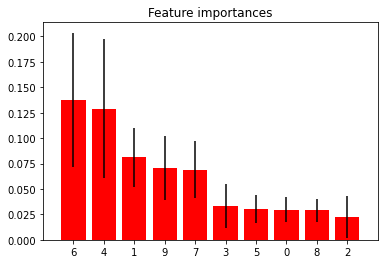

In [119]:
train_index,test_index = train_test_split(data.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = numpy.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = numpy.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
#import pylab as pl
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

### Thinking in Probabilities
决策往往有利于简单分类的概率。在“明天有20％的机会下雨”和“大约55％的考生通过加利福尼亚酒吧考试”这样的表述中，比只是说“明天不应该下雨”或“你可能会通过”更有效用。流失的概率预测也使我们能够衡量客户的预期价值及其预期的损失。谁想要首先接触客户，每年支付20万美元的80％的流失风险，或每年价值10万的客户，风险为40％？ 你应该在每个客户端上花多少钱？

“scikit-learn”使得概率变得容易; 我的三个模型已经将predict_proba（）构建到他们的类对象中。这是相同的交叉验证码，只有几行改变。

In [121]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = numpy.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

### 什么是最好的算法？
确定给出概率而不是类的预测因子有一定的难度。如果我预测明天有20％的可能性会下雨的，比告诉你下雨还是不下雨更好。 所以每次我预测一个事件发生20％的时间，我可以看到这些事件实际发生的频率。 这里我们将使用“pandas”来帮助我比较随机森林对实际结果的预测。

In [125]:
import warnings
warnings.filterwarnings('ignore')

# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pandas.value_counts(pred_churn)
counts[:]

TypeError: __init__() got an unexpected keyword argument 'n_folds'

In [126]:
from collections import defaultdict
true_prob = defaultdict(float)

# calculate true probabilities
for prob in counts.index:
    true_prob[prob] = numpy.mean(is_churn[pred_churn == prob])
true_prob = pandas.Series(true_prob)

# pandas-fu
counts = pandas.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

NameError: name 'counts' is not defined

我们可以发现随机森林预测了有75个案例有90%的概率会流失，而实际中改组有97%的比例流失了。

### 校准和鉴别
使用上面的DataFrame我可以绘制一个非常简单的图形，以帮助可视化概率测量。 x轴表示随机森林分配给一组个体的流失概率。 y轴是该组内实际的流失概率，每个点相对于组的大小进行缩放。校准是一个相对简单的测量，可以总结如下：预测发生的事件60％的时间应该发生在60％的时间。对于所有个人，我预测流失风险在30％至40％之间，该组的真正流失率应为35％左右。对于上面的图表，想到这一点，我对红线的预测有多接近？

歧视措施_我的预测远离绿线？_为什么这么重要？

那么，如果我们为每个人分配15％的流失概率，我们将会因为平均值而接近完美的校准，但是我将缺乏真正的洞察力。如果鉴别能够隔离更远离基础组的组，它给予一个更好的分数的模型

公式来自于 Yang, Yates, and Smith (1991)

In [128]:
from __future__ import division
import numpy as np


def calibration(prob,outcome,n_bins=10):
    """Calibration measurement for a set of predictions.
    When predicting events at a given probability, how far is frequency
    of positive outcomes from that probability?
    NOTE: Lower scores are better
    prob: array_like, float
        Probability estimates for a set of events
    outcome: array_like, bool
        If event predicted occurred
    n_bins: int
        Number of judgement categories to prefrom calculation over.
        Prediction are binned based on probability, since "descrete" 
        probabilities aren't required. 
    """
    prob = np.array(prob)
    outcome = np.array(outcome)

    c = 0.0
    # Construct bins
    judgement_bins = np.arange(n_bins + 1) / n_bins
    # Which bin is each prediction in?
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        # Is event in bin
        in_bin = bin_num == j_bin
        # Predicted probability taken as average of preds in bin
        predicted_prob = np.mean(prob[in_bin])
        # How often did events in this bin actually happen?
        true_bin_prob = np.mean(outcome[in_bin])
        # Squared distance between predicted and true times num of obs
        c += np.sum(in_bin) * ((predicted_prob - true_bin_prob) ** 2)
    return c / len(prob)

def discrimination(prob,outcome,n_bins=10):
    """Discrimination measurement for a set of predictions.
    For each judgement category, how far from the base probability
    is the true frequency of that bin?
    NOTE: High scores are better
    prob: array_like, float
        Probability estimates for a set of events
    outcome: array_like, bool
        If event predicted occurred
    n_bins: int
        Number of judgement categories to prefrom calculation over.
        Prediction are binned based on probability, since "descrete" 
        probabilities aren't required. 
    """
    prob = np.array(prob)
    outcome = np.array(outcome)

    d = 0.0
    # Base frequency of outcomes
    base_prob = np.mean(outcome)
    # Construct bins
    judgement_bins = np.arange(n_bins + 1) / n_bins
    # Which bin is each prediction in?
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        true_bin_prob = np.mean(outcome[in_bin])
        # Squared distance between true and base times num of obs
        d += np.sum(in_bin) * ((true_bin_prob - base_prob) ** 2)
    return d / len(prob)

In [132]:
from sklearn.metrics import roc_curve, auc
import scipy
from scipy import interp
from __future__ import division 
from operator import *


      
def print_measurements(pred_prob):
    churn_prob, is_churn = pred_prob[:,1], y == 1
    print (("  %-20s %.4f" )% ("Calibration Error", calibration(churn_prob, is_churn)))
    print (("  %-20s %.4f") % ("Discrimination", discrimination(churn_prob,is_churn)))

    print ("Note -- Lower calibration is better, higher discrimination is better")
print ("Support vector machines:")
print_measurements(run_prob_cv(X,y,SVC,probability=True))

print ("Random forests:")
print_measurements(run_prob_cv(X,y,RF,n_estimators=18))

print ("K-nearest-neighbors:")
print_measurements(run_prob_cv(X,y,KNN))

print ("Gradient Boosting Classifier:")
print_measurements(run_prob_cv(X,y,GBC))

print ("Random Forest:")
print_measurements(run_prob_cv(X,y,RF))

SyntaxError: import * only allowed at module level (<ipython-input-132-b80c6c8f4cbc>, line 2)

与之前的分类比较不同，随机森林在这里并不明显。 虽然它有利于区分高概率和低概率流失事件，但是在为这些事件分配准确的概率估计时遇到困难。 例如，随机森林预测具有30％流失率的组实际上的真正流失率为14％。